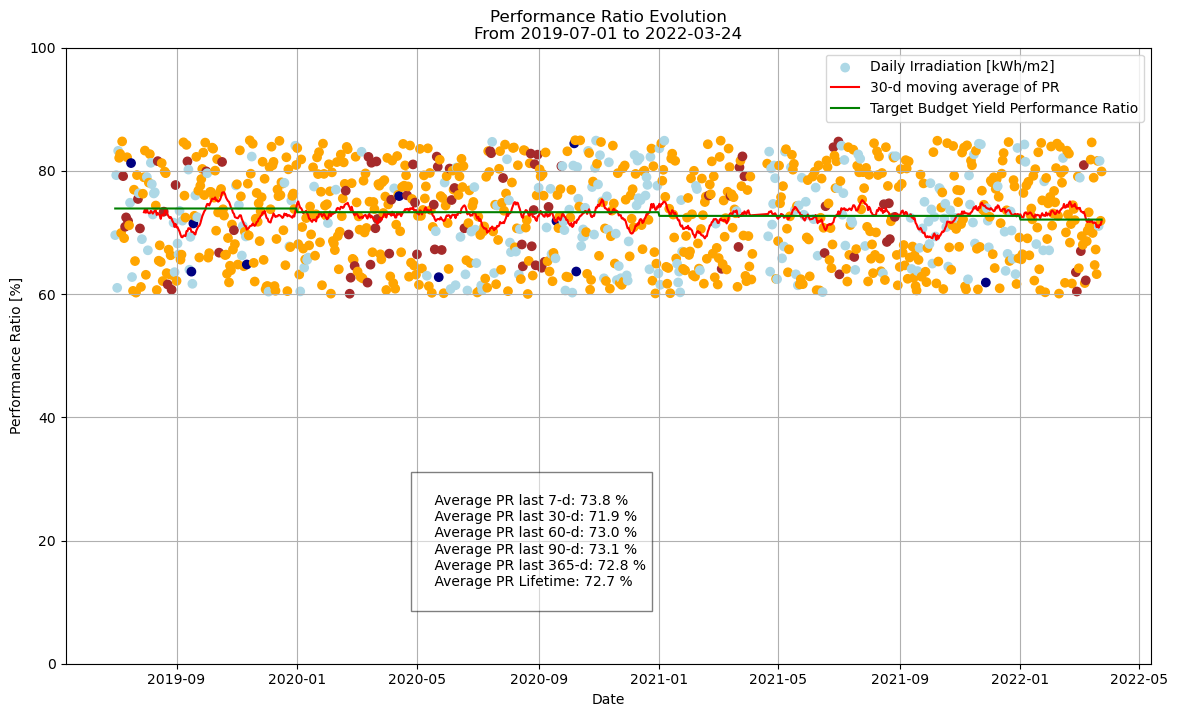

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def load_data_in_chunks(file_path, chunk_size=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

def moving_average(data, window_size=30):
    return data.rolling(window=window_size).mean()

def calculate_budget_pr(date_column):
    budget_pr = []
    base_pr = 73.9
    start_year = pd.to_datetime(date_column.min()).year
    for date in date_column:
        year_diff = pd.to_datetime(date).year - start_year
        budget_pr.append(base_pr - year_diff * 0.6)  
    return budget_pr

def generate_pr_graph(data):
    data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
    data.sort_values('Date', inplace=True)

    data['Budget PR'] = calculate_budget_pr(data['Date'])

    data['30d_MA_PR'] = moving_average(data['PR'])

    conditions = [
        (data['GHI'] < 2),
        (data['GHI'] >= 2) & (data['GHI'] < 4),
        (data['GHI'] >= 4) & (data['GHI'] < 6),
        (data['GHI'] >= 6)
    ]
    colors = ['navy', 'lightblue', 'orange', 'brown']
    data['Color'] = np.select(conditions, colors, default='gray')

    plt.figure(figsize=(14, 8))
    plt.scatter(data['Date'], data['PR'], c=data['Color'], label='Daily Irradiation [kWh/m2]')
    plt.plot(data['Date'], data['30d_MA_PR'], color='red', label='30-d moving average of PR')
    plt.plot(data['Date'], data['Budget PR'], color='green', label='Target Budget Yield Performance Ratio')

    plt.title("Performance Ratio Evolution\nFrom {} to {}".format(data['Date'].min().strftime('%Y-%m-%d'),
                                                                  data['Date'].max().strftime('%Y-%m-%d')))
    plt.xlabel("Date")
    plt.ylabel("Performance Ratio [%]")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.ylim(0, 100)
    
    stats_text = f"""
    Average PR last 7-d: {data['PR'].tail(7).mean():.1f} %
    Average PR last 30-d: {data['PR'].tail(30).mean():.1f} %
    Average PR last 60-d: {data['PR'].tail(60).mean():.1f} %
    Average PR last 90-d: {data['PR'].tail(90).mean():.1f} %
    Average PR last 365-d: {data['PR'].tail(365).mean():.1f} %
    Average PR Lifetime: {data['PR'].mean():.1f} %
    """
    plt.text(pd.to_datetime('2020-05-01'), 10, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.savefig('output_image.png', format='png', dpi=300, bbox_inches='tight')
    
    plt.show()

file_path = "C:\\Users\\Prem\\Desktop\\SEM7\\PLACEMENT\\PV_Doctor_Internship\\data - Copy\\cleaned_combined_output.csv"
data = load_data_in_chunks(file_path)

generate_pr_graph(data)
